In [1]:
#Signature Authenticity Analysis System Using Support Vector Machine Algorithm
%pip install opencv-contrib-python
%pip install scikit-image
%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import cv2
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from skimage.feature import hog, local_binary_pattern
from skimage.filters import gabor
from skimage.morphology import skeletonize
from skimage.util import invert
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
def load_dataset(base_path):
    X_paths, y_labels = [], []
    # Pairs of (folder, label):
    sources = [
        ('genuine',        1),
        ('augmented_genuine', 1),
        ('forged',         0),
        ('augmented_forged', 0)
    ]
    for subdir, label in sources:
        root = os.path.join(base_path, subdir)
        for person in os.listdir(root):
            folder = os.path.join(root, person)
            if not os.path.isdir(folder):
                continue
            # collect all common image types
            for ext in ('*.png','*.jpg','*.jpeg','*.tif'):
                for img_path in glob(os.path.join(folder, ext)):
                    X_paths.append(img_path)
                    y_labels.append(label)
    return X_paths, y_labels

In [4]:
def display_signature(base_path, num_images=5):

    person = next(os.walk(os.path.join(base_path, 'genuine')))[1][0]
    real_folder   = os.path.join(base_path, 'genuine', person)
    forged_folder = os.path.join(base_path, 'forged', person + '_forg')


    # List and sort files
    real_files   = sorted([f for f in os.listdir(real_folder)   if f.lower().endswith(('.png','.jpg','.jpeg','.tif'))])
    forged_files = sorted([f for f in os.listdir(forged_folder) if f.lower().endswith(('.png','.jpg','.jpeg','.tif'))])


    # Limit to num_images
    real_files   = real_files[:num_images]
    forged_files = forged_files[:num_images]
    N = min(len(real_files), len(forged_files))

    # Plot grid: 2 rows × N cols
    fig, axes = plt.subplots(2, N, figsize=(N * 2.5, 5))
    for i in range(N):
        # Real
        img_r = mpimg.imread(os.path.join(real_folder, real_files[i]))
        ax = axes[0, i] if N>1 else axes[0]
        ax.imshow(img_r, cmap='gray')
        ax.axis('off')
        ax.set_title('Real Signature', fontsize=9)

        # Forged
        img_f = mpimg.imread(os.path.join(forged_folder, forged_files[i]))
        ax = axes[1, i] if N>1 else axes[1]
        ax.imshow(img_f, cmap='gray')
        ax.axis('off')
        ax.set_title('Forged Signature', fontsize=9)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

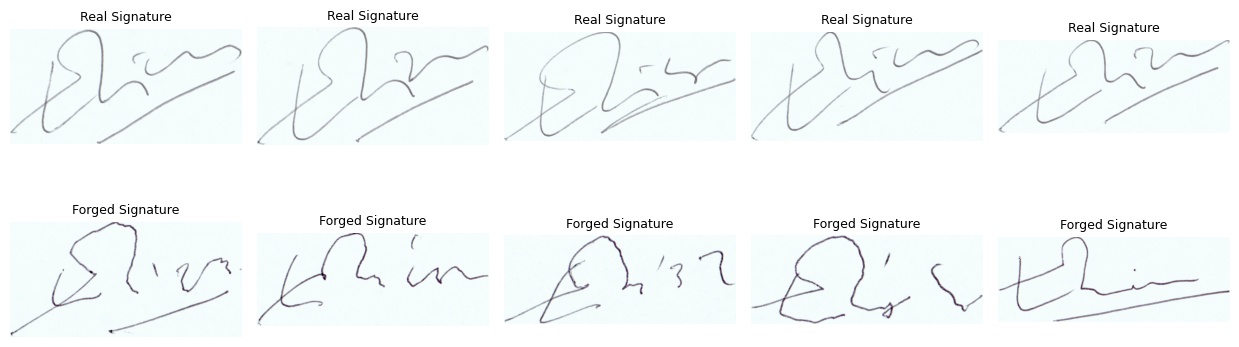

In [5]:
# Update this to your root data folder
BASE_PATH = r'D:\Users\predator\Desktop\Project_Cap\DatasetLarge\sign_data'
X_paths, y = load_dataset(BASE_PATH)
display_signature(BASE_PATH, num_images=5)


In [6]:
# Count total and augmented images
real_images = [p for p, label in zip(X_paths, y) if 'genuine' in p and 'augmented' not in p]
forged_images = [p for p, label in zip(X_paths, y) if 'forged' in p and 'augmented' not in p]
real_augmented_images = [p for p, label in zip(X_paths, y) if 'augmented_genuine' in p]
forged_augmented_images = [p for p, label in zip(X_paths, y) if 'augmented_forged' in p]

print("Total Real Images:", len(real_images))
print("Total Forged Images:", len(forged_images))
print("Total Real Augmented Images:", len(real_augmented_images))
print("Total Forged Augmented Images:", len(forged_augmented_images))
print("Total Images:", len(X_paths))


Total Real Images: 1654
Total Forged Images: 1517
Total Real Augmented Images: 1654
Total Forged Augmented Images: 1517
Total Images: 6342


In [7]:
#  Preprocess & extract features ---

def extract_features(path):
    # Load & preprocess
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256,256))
    
    #Noise reduction Preprocessing for edge detection Feature smoothing before extraction
    blur = cv2.GaussianBlur(img, (5,5), 0) 
    _, bw = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    feats = []

    #  Hu Moments 7 -> 	Edge and stroke direction/texture differences
    hu = cv2.HuMoments(cv2.moments(bw)).flatten() 
    feats.extend(np.log1p(np.abs(hu)))

    #  HOG 8100 -> HOG for edge directions and patterns
    hog_fd = hog(bw, pixels_per_cell=(16,16), cells_per_block=(2,2), feature_vector=True)
    feats.extend(hog_fd)

    # LBP histogram 10 ->Texture and ink pattern variations
    lbp = local_binary_pattern(bw, P=8, R=1, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
    feats.extend((hist / (hist.sum()+1e-6)).tolist())

    #  Skeleton Length 1 -> Stroke complexity or length variations
    try:
        skel = cv2.ximgproc.thinning(bw)
        feats.append(float(np.sum(skel>0)))
    except:
        feats.append(0.0)

    #  Contour descriptors 5 -> Size, shape compactness, smoothness, stroke coverage changes
    cnts, _ = cv2.findContours(bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if cnts:
        c = max(cnts, key=cv2.contourArea)
        area = cv2.contourArea(c)
        perim = cv2.arcLength(c, True)
        x,y,w,h = cv2.boundingRect(c)
        aspect = float(w)/h if h>0 else 0
        rect_area = w*h
        extent = float(area)/rect_area if rect_area>0 else 0
        hull = cv2.convexHull(c)
        hull_area = cv2.contourArea(hull)
        solidity = float(area)/hull_area if hull_area>0 else 0
    else:
        area = perim = aspect = extent = solidity = 0.0

    feats.extend([area, perim, aspect, extent, solidity])
    return np.array(feats, dtype=np.float32)

In [8]:
# Build feature matrix
print("Extracting features from images...")
X = np.array([extract_features(p) for p in X_paths])
y = np.array(y)
print(f" Total Samples -> {len(X)} samples, {X.shape[1]} features each")

# Handle class imbalance ---
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)
print(f"After oversampling: {len(y_res)} samples (class counts {np.bincount(y_res)})")

Extracting features from images...
 Total Samples -> 6342 samples, 8123 features each
After oversampling: 6616 samples (class counts [3308 3308])


In [ ]:
# Train/Test split ---

X_temp, X_test, y_temp, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, random_state=42, stratify=y_temp)

print("Training samples:", len(X_train))
print("Validation data size:", len(X_val))
print("Testing samples: ", len(X_test))

Training samples: 4630
Validation data size: 662
Testing samples:  1324


In [10]:
# Scale + train SVM --- standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

In [11]:
svm = SVC(kernel='rbf', probability=True, random_state=42)
print("Training SVM...")
svm.fit(X_train_s, y_train)

val_score = svm.score(X_val_scaled, y_val)
print("Validation score:", val_score)

Training SVM...
Validation score: 0.879154078549849


In [ ]:
# Evaluate ---

y_pred = svm.predict(X_test_s)
y_prob = svm.predict_proba(X_test_s)[:,1]

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Forged','Genuine']))


Classification Report:
              precision    recall  f1-score   support

      Forged       0.90      0.86      0.88       662
     Genuine       0.86      0.90      0.88       662

    accuracy                           0.88      1324
   macro avg       0.88      0.88      0.88      1324
weighted avg       0.88      0.88      0.88      1324



In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming y_test contains true labels and y_pred contains predicted labels
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall    = recall_score(y_test, y_pred, pos_label=1)
f1        = f1_score(y_test, y_pred, pos_label=1)

print(f"Accuracy: {accuracy*100:.4f} %")
print(f"Precision : {precision*100:.4f}%")
print(f"Recall: {recall*100:.4f}%")
print(f"F1 Score: {f1*100:.4f}%")


Accuracy: 87.9154 %
Precision : 86.3768%
Recall: 90.0302%
F1 Score: 88.1657%


Confusion Matrix:
[[568  94]
 [ 66 596]]


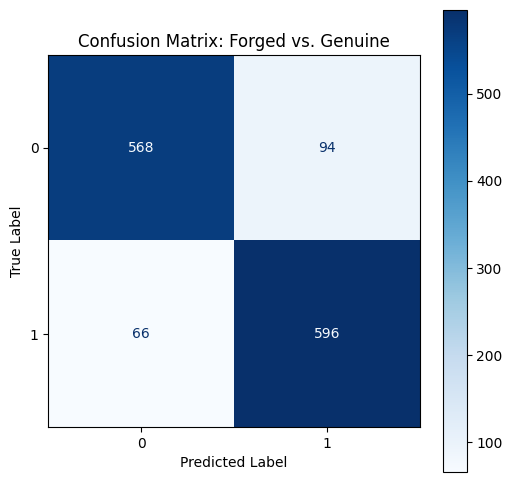

In [14]:
#  Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=svm.classes_)

#  Print the raw confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm.classes_)
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=True)
plt.title("Confusion Matrix: Forged vs. Genuine")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [15]:
# Predict on training data
y_train_pred = svm.predict(X_train_s)

# Compute training accuracy
train_acc = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_acc * 100:.2f}%")

# Compute testing accuracy
print(f"Testing Accuracy:  {accuracy * 100:.2f}%")



Training Accuracy: 96.18%
Testing Accuracy:  87.92%


In [16]:
from sklearn.metrics import confusion_matrix

# Assuming y_test are the true labels and y_pred are predicted labels
# 1 = Genuine, 0 = Forged
tn, fp, fn, tp = cm.ravel()

# Calculate FAR and FRR
far = fp / (fp + tn)  # False Acceptance Rate
frr = fn / (fn + tp)  # False Rejection Rate

print(f"False Acceptance Rate (FAR): {far:.4f}")
print(f"False Rejection Rate (FRR): {frr:.4f}")


False Acceptance Rate (FAR): 0.1420
False Rejection Rate (FRR): 0.0997


ROC AUC: 0.9333715920811237


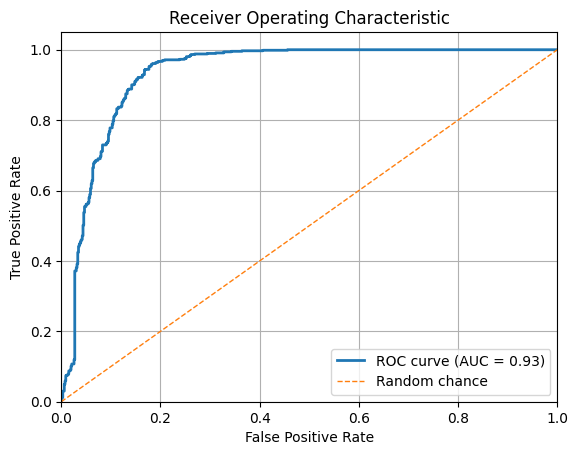

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

print("ROC AUC:", roc_auc_score(y_test, y_prob))
# Compute false positive rate (fpr), true positive rate (tpr), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute AUC (Area Under Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, label='Random chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [19]:
# At the end of finalTry.ipynb
import joblib
# assuming your model object is named `clf`
joblib.dump(svm, 'signature_system.pkl')
joblib.dump(scaler, 'scaler_signature.pkl')

['scaler_signature.pkl']

code to agument the data

In [20]:
%pip install --user albumentations
import os
import cv2
import albumentations as A
from tqdm import tqdm

# Source and destination base paths
base = r"D:\Users\predator\Desktop\Project_Cap\DatasetLarge\sign_data"
genuine_root       = os.path.join(base, "genuine")
forged_root        = os.path.join(base, "forged")
aug_genuine_root   = os.path.join(base, "augmented_genuine")
aug_forged_root    = os.path.join(base, "augmented_forged")

# Number of augmentations per image
num_augments = 1

# New augmentation pipeline with only 3 types
augment = A.Compose([
    A.Rotate(limit=10, p=0.8),
    
])

def augment_folder_images(src_root, dst_root, suffix):
    for person in tqdm(os.listdir(src_root), desc=os.path.basename(src_root)):
        src_folder = os.path.join(src_root, person)
        dst_folder = os.path.join(dst_root, person)

        if not os.path.isdir(src_folder):
            continue

        os.makedirs(dst_folder, exist_ok=True)

        for img_file in os.listdir(src_folder):
            if not img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue

            img_path = os.path.join(src_folder, img_file)
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if image is None:
                print(f"Warning: could not read {img_path}")
                continue

            base_name, _ = os.path.splitext(img_file)
            for i in range(num_augments):
                augmented = augment(image=image)["image"]
                new_name = f"{base_name}_aug{i+1}{suffix}.png"
                save_path = os.path.join(dst_folder, new_name)
                cv2.imwrite(save_path, augmented)

# Run augmentation for both genuine and forgeda
augment_folder_images(genuine_root, aug_genuine_root, "_genuine")
augment_folder_images(forged_root, aug_forged_root, "_forged")
